In [1]:
import pandas as pd 
import cv2 
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import src.image_folders as F
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


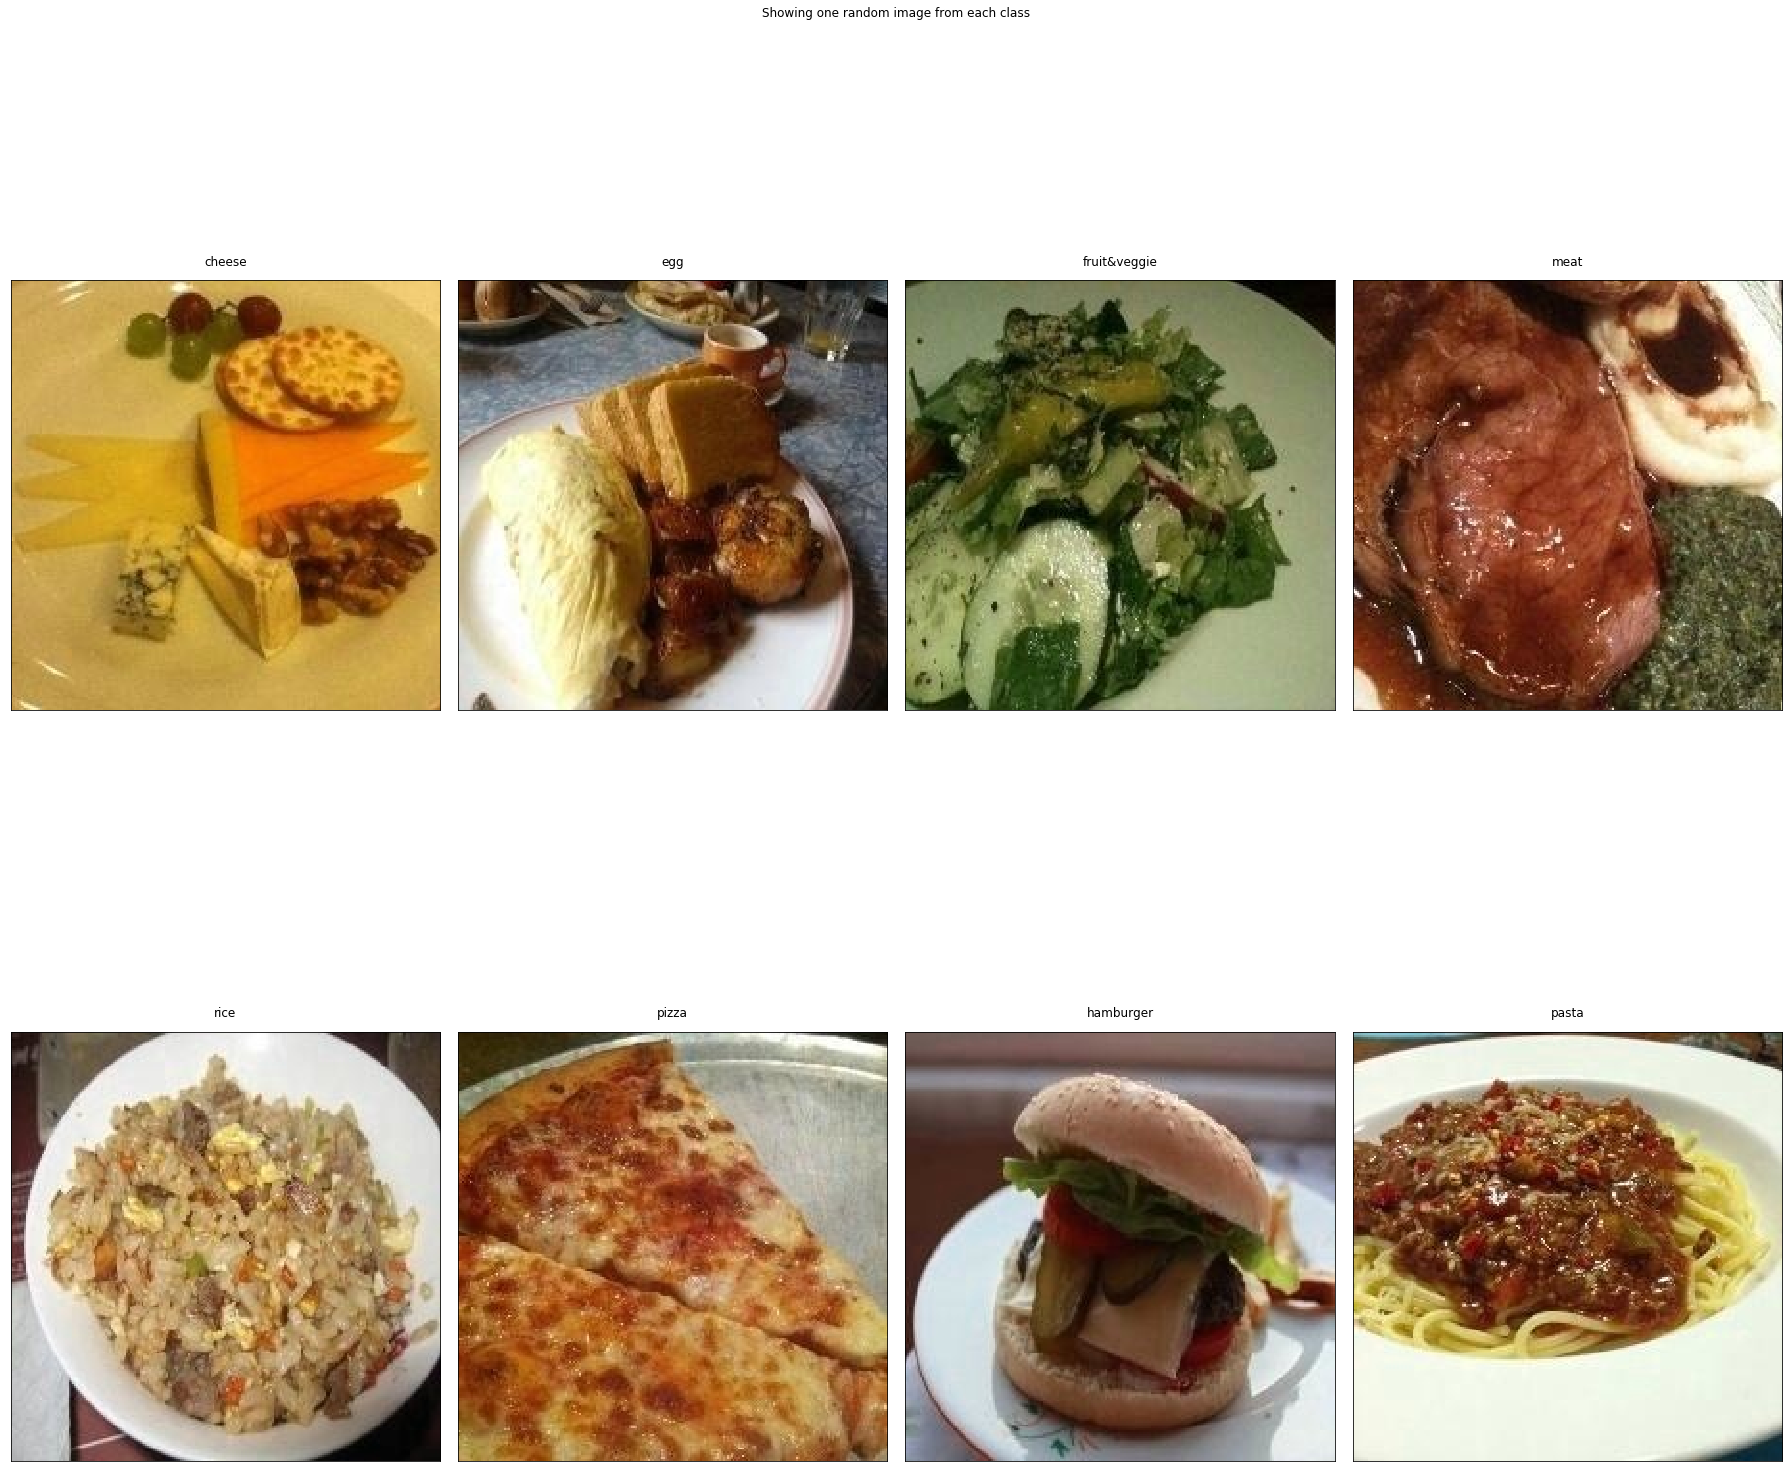

In [2]:
path ='food/'
food_dir = os.listdir(path)
rows = 2
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class") 
food_id = 0
list_of_imgs = {}
for i in range(rows):
    for j in range(cols):
        food_selected = food_dir[food_id] 
        food_id += 1
        food_selected_images = os.listdir(os.path.join(path,food_selected))
        list_of_imgs[food_selected]=food_selected_images
        food_selected_random = np.random.choice(food_selected_images)
        img = plt.imread(os.path.join(path,food_selected,food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 15)
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [3]:
# Obtain diccionaries with entire path of images as values and the respective class as keys 
dic_paths = {}
for folder in list_of_imgs.keys():
    list_paths = []
    for file in list_of_imgs[folder]:
        list_paths.append(os.path.join(path,folder,file)) 
    dic_paths[folder] = list_paths

In [4]:
path_train_X, path_test_X = {}, {}
for classes in dic_paths.keys():
    list_of_images = dic_paths[classes]
    path_train_X[classes] = list_of_images[:800]
    path_test_X[classes] = list_of_images[800:]

In [5]:
F.move_images(path_train_X, "train")
F.move_images(path_test_X, "test")

In [6]:
train_X, test_X = [],[]
for split in [("train",train_X),("test",test_X)]:
    filenames = os.listdir(os.path.join(path,split[0]))
    for file in filenames:
        img = img = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(path,split[0],file)), cv2.COLOR_BGR2RGB), (224, 224))
        split[1].append(img.astype(np.float32))

In [7]:
#probar
train_X = np.array(train_X)
test_X = np.array(test_X)

In [8]:
num_classes = 8
y_train = np.concatenate((np.zeros(800),np.ones(800), np.array([float(2)]*800),np.array([float(3)]*800),np.array([float(4)]*800),np.array([float(5)]*800),np.array([float(6)]*800),np.array([float(7)]*800)))
y_test = np.concatenate((np.zeros(200),np.ones(200),np.array([float(2)]*200),np.array([float(3)]*200),np.array([float(4)]*200),np.array([float(5)]*200),np.array([float(6)]*200),np.array([float(7)]*200)))
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes, dtype='float32')

In [9]:
train_X.shape

(6400, 224, 224, 3)

In [10]:
MEAN = np.mean(train_X, axis = (0,1,2))
STD = np.std(train_X, axis = (0,1,2))
print(MEAN, STD)

[13.374694 13.374694 13.374694] [58.514286 58.514286 58.514286]


In [11]:
for i in range(3):
    train_X[:, :, :, i] = (train_X[:, :, :, i] - MEAN[i]) / STD[i]
    test_X[:, :, :, i] = (test_X[:, :, :, i] - MEAN[i]) / STD[i]

In [12]:
# Step 1 - Convolution
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.01))
# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(activation = 'relu', units=128))
model.add(Dense(activation = 'relu',units=128))
model.add(Dense(activation = 'relu', units=128))
model.add(Dense(activation = 'softmax', units=8))

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 400
epochs = 25
model.fit(train_X, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(test_X, y_test))

model.summary() 


Train on 6400 samples, validate on 1600 samples
Epoch 1/25


In [ ]:
score = model.evaluate(test_X, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from keras.models import load_model 
model.save('my_model.h5')

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Use argmax to project output probabilites as class index label
proba = model.predict(test_X)
print(proba[0])
y_pred = np.argmax(proba, axis=1)
print(y_pred[0])
y_t = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t, y_pred)
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray")

plt.xlabel("GT")
plt.ylabel("Predicted")
plt.title(f"Test data = {len(y_pred)} samples")
plt.show()

In [ ]:
img = X_test[30]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print("Probs -> Cat:{0:.5f} Dog:{1:.5f}".format(pred[0],pred[1]))
plt.imshow(Image.fromarray(img.squeeze()*255),'gray')